# 构建投资组合

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import datetime

from pathlib import Path
import sys
import os
root_dir = str(Path(os.getcwd()).parent)
sys.path.append(root_dir)

from report.evaluate.protfolio import get_protfolio_net_value

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

## 每季度完成一次投资统计净值变化

In [2]:
trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
yysj_pro = pq.read_table(f'{root_dir}/data/intermediate_results/yysj_pro.parquet').to_pandas()
factor_data = pq.read_table(f'{root_dir}/data/intermediate_results/factor_data.parquet').to_pandas()[['stock_symbol', 'trade_date', 'is_suspended', 'is_st', 'listed_date', 'close']]

protfolio = pd.merge(left=trade_date_lag, right=yysj_pro, on=['stock_symbol', 'report_type'], how='left')
protfolio = pd.merge(left=protfolio, right=factor_data, on=['stock_symbol', 'trade_date'], how='left')

# protfolio = protfolio.loc[(protfolio['days_to_deadline']>0) & 
#                           (protfolio['is_suspended'] == False) &
#                           (protfolio['is_st'] == False) &
#                           (protfolio['trade_date'] >= (protfolio['listed_date'] + datetime.timedelta(days=365)))] 
# protfolio = protfolio.dropna(subset='close')
protfolio

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,book_time_rank_last,report_time_rank_last,days_to_deadline,is_suspended,is_st,listed_date,close
0,000001,20061231,2007-02-01,-30,0.280156,0.280156,0.280934,39.0,False,False,1991-04-03,3.6962
1,000002,20061231,2007-01-30,-30,0.248249,0.248249,0.248249,41.0,False,False,1991-01-29,4.2204
2,000004,20061231,2007-03-16,-30,0.874708,0.874708,0.875486,3.0,False,True,1990-12-01,6.7000
3,000006,20061231,2007-02-05,-30,0.309728,0.309728,0.309728,37.0,False,False,1992-04-27,1.5255
4,000007,20061231,2007-03-09,-30,0.734630,0.734630,0.737743,10.0,False,False,1992-04-13,2.8133
...,...,...,...,...,...,...,...,...,...,...,...,...
12428196,688799,20240630,2024-10-23,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12428197,688800,20240630,2024-10-14,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12428198,688819,20240630,2024-10-21,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12428199,688981,20240630,2024-10-22,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 发报前买入早公告
protfolio1 = get_protfolio_net_value(-10, -1, protfolio, head=False)
# 发报前买入晚公告
protfolio2 = get_protfolio_net_value(-10, -1, protfolio, head=True)
# 发报后买入早公告
protfolio3 = get_protfolio_net_value(1, 10, protfolio, head=False)
# 发报后买入晚公告
protfolio4 = get_protfolio_net_value(1, 10, protfolio, head=True)

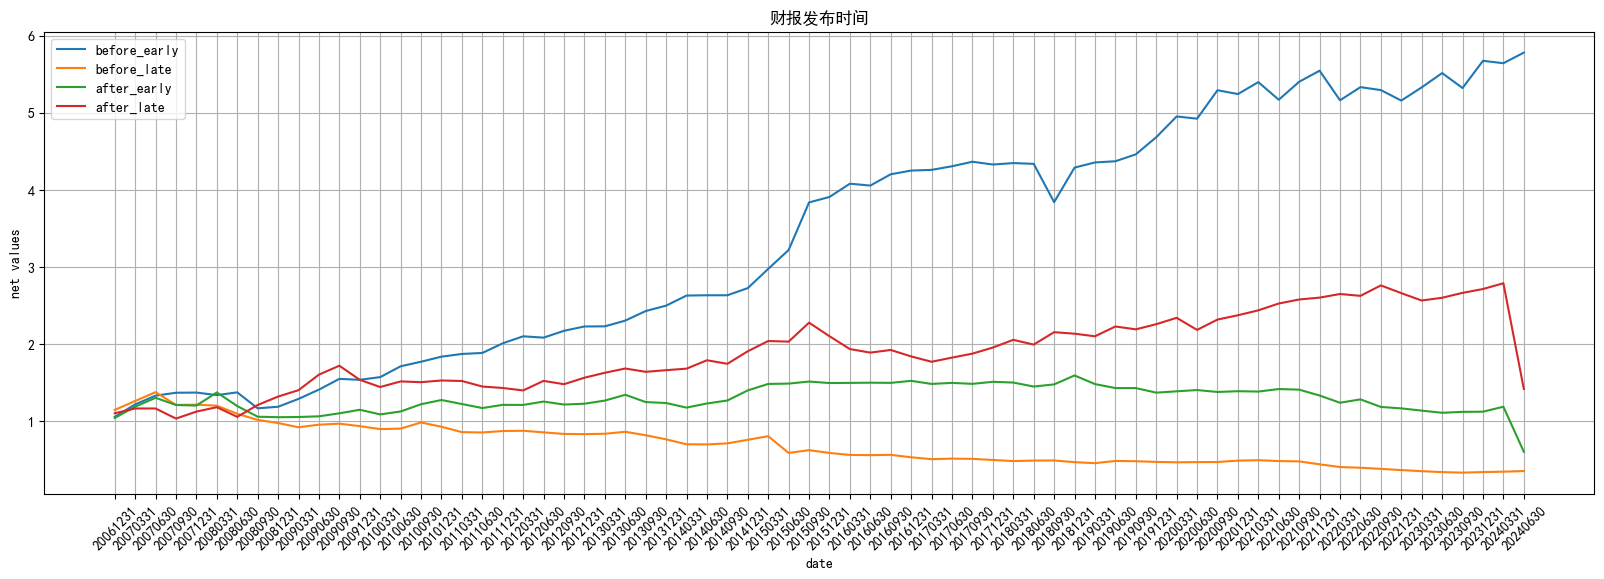

In [4]:
plt.figure(figsize=(20, 6))

# 创建折线图
plt.plot(protfolio1['report_type'], protfolio1['net_value'], linestyle='-', label='before_early')
plt.plot(protfolio2['report_type'], protfolio2['net_value'], linestyle='-', label='before_late')

plt.plot(protfolio3['report_type'], protfolio3['net_value'], linestyle='-', label='after_early')
plt.plot(protfolio4['report_type'], protfolio4['net_value'], linestyle='-', label='after_late')
# 旋转横坐标标签
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('财报发布时间')
plt.xlabel('date')
plt.ylabel('net values')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True) 
plt.show()

# 分层

In [5]:
start = -10
end = -1

group = protfolio.loc[(protfolio['lag']==start)]
group = group.loc[(group['days_to_deadline']>0) & 
                          (group['is_suspended'] == False) &
                          (group['is_st'] == False) &
                          (group['trade_date'] >= (group['listed_date'] + datetime.timedelta(days=365)))] 
group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values

group_end = protfolio.loc[(protfolio['lag']==end), ['stock_symbol', 'report_type', 'trade_date', 'close']]

group = pd.merge(left=group[['stock_symbol', 'report_type', 'trade_date', 'close', 'group']], right=group_end, on=['stock_symbol', 'report_type'], how='left')

group = group.groupby(['report_type', 'group'])[['close_x', 'close_y']].mean().reset_index()
group['rets'] = group['close_y'] / group['close_x']
group['net_value'] = group.groupby('group')['rets'].cumprod()
group

C:\Users\plucky\AppData\Local\Temp\ipykernel_18324\1631749482.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values


,report_type,group,close_x,close_y,rets,net_value
0,20061231,0,5.464280,6.176091,1.130266,1.130266
1,20061231,1,5.300597,5.668056,1.069324,1.069324
2,20061231,2,4.400746,4.741912,1.077524,1.077524
3,20061231,3,3.953223,4.121438,1.042551,1.042551
4,20061231,4,3.480312,3.856064,1.107965,1.107965
...,...,...,...,...,...,...
344,20240331,4,31.197500,31.317300,1.003840,4.429929
345,20240630,0,11.270000,NaN,NaN,NaN
346,20240630,2,23.485120,22.950500,0.977236,2.480465
347,20240630,3,22.184995,22.442045,1.011587,15.177950


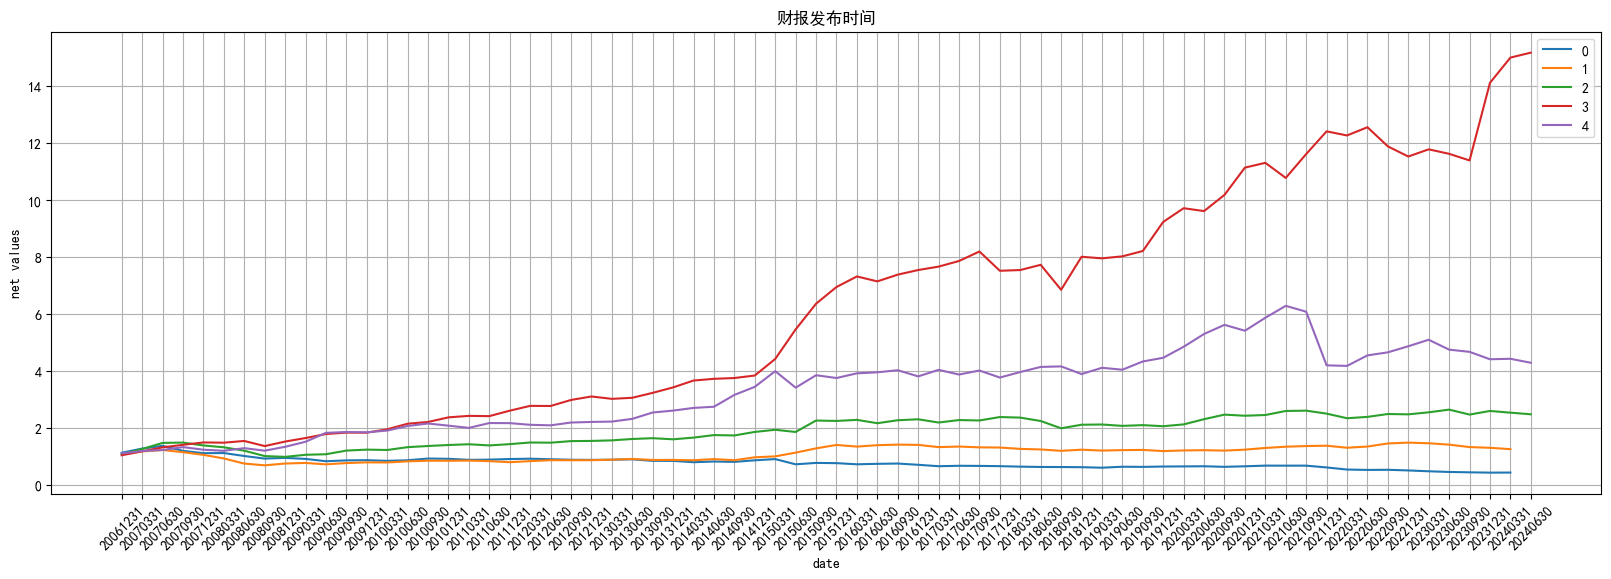

In [6]:
plt.figure(figsize=(20, 6))

# 创建折线图
plt.plot(group.loc[group['group']==0, 'report_type'], group.loc[group['group']==0, 'net_value'], linestyle='-', label='0')
plt.plot(group.loc[group['group']==1, 'report_type'], group.loc[group['group']==1, 'net_value'], linestyle='-', label='1')
plt.plot(group.loc[group['group']==2, 'report_type'], group.loc[group['group']==2, 'net_value'], linestyle='-', label='2')
plt.plot(group.loc[group['group']==3, 'report_type'], group.loc[group['group']==3, 'net_value'], linestyle='-', label='3')
plt.plot(group.loc[group['group']==4, 'report_type'], group.loc[group['group']==4, 'net_value'], linestyle='-', label='4')
# 旋转横坐标标签
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('财报发布时间')
plt.xlabel('date')
plt.ylabel('net values')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True) 
plt.show()

In [7]:
start = 1
end = 10

group = protfolio.loc[(protfolio['lag']==start)]
group = group.loc[(group['days_to_deadline']>0) & 
                          (group['is_suspended'] == False) &
                          (group['is_st'] == False) &
                          (group['trade_date'] >= (group['listed_date'] + datetime.timedelta(days=365)))] 
group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values

group_end = protfolio.loc[(protfolio['lag']==end), ['stock_symbol', 'report_type', 'trade_date', 'close']]

group = pd.merge(left=group[['stock_symbol', 'report_type', 'trade_date', 'close', 'group']], right=group_end, on=['stock_symbol', 'report_type'], how='left')

group = group.groupby(['report_type', 'group'])[['close_x', 'close_y']].mean().reset_index()
group['rets'] = group['close_y'] / group['close_x']
group['net_value'] = group.groupby('group')['rets'].cumprod()
group

C:\Users\plucky\AppData\Local\Temp\ipykernel_18324\3435960061.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values


,report_type,group,close_x,close_y,rets,net_value
0,20061231,0,6.322699,7.133105,1.128174,1.128174
1,20061231,1,5.707498,6.330851,1.109217,1.109217
2,20061231,2,4.747809,5.101235,1.074440,1.074440
3,20061231,3,4.269155,4.432100,1.038168,1.038168
4,20061231,4,3.989585,4.192141,1.050771,1.050771
...,...,...,...,...,...,...
345,20240630,0,24.400000,NaN,NaN,NaN
346,20240630,1,23.473000,NaN,NaN,NaN
347,20240630,2,12.993333,NaN,NaN,NaN
348,20240630,3,7.680000,7.900000,1.028646,0.655128


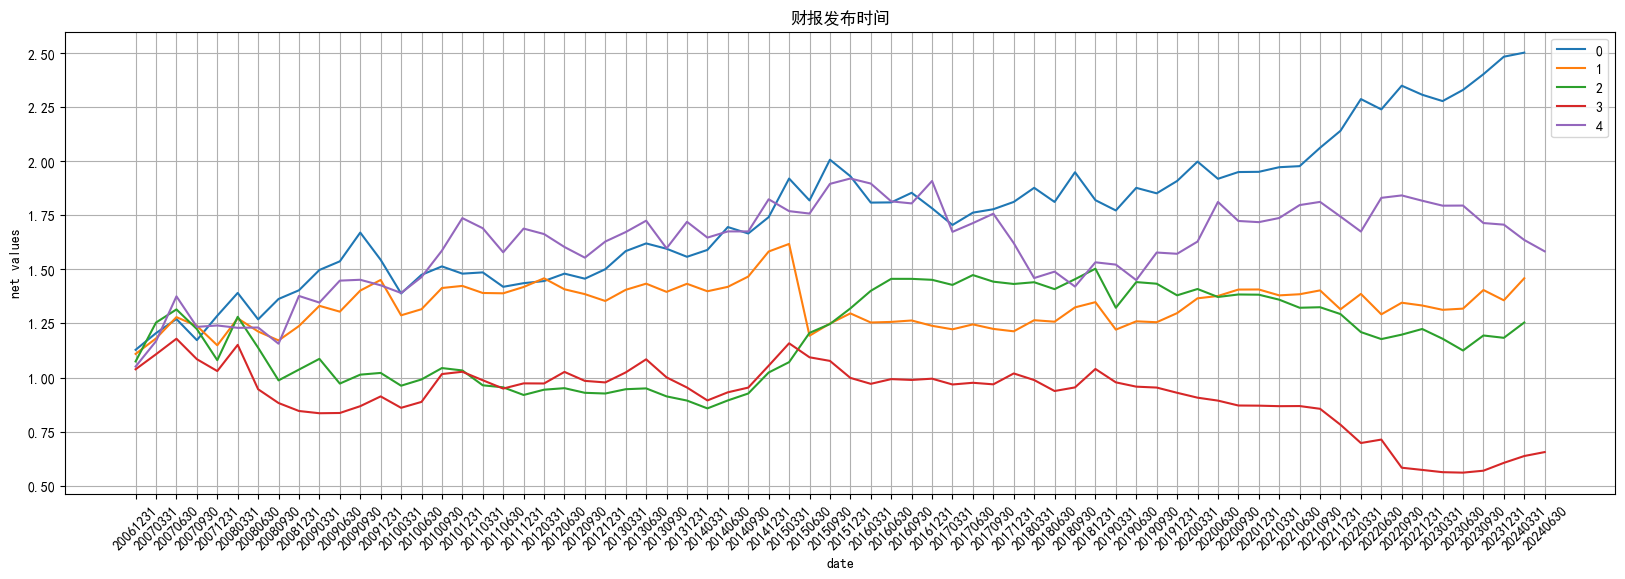

In [8]:
plt.figure(figsize=(20, 6))

# 创建折线图
plt.plot(group.loc[group['group']==0, 'report_type'], group.loc[group['group']==0, 'net_value'], linestyle='-', label='0')
plt.plot(group.loc[group['group']==1, 'report_type'], group.loc[group['group']==1, 'net_value'], linestyle='-', label='1')
plt.plot(group.loc[group['group']==2, 'report_type'], group.loc[group['group']==2, 'net_value'], linestyle='-', label='2')
plt.plot(group.loc[group['group']==3, 'report_type'], group.loc[group['group']==3, 'net_value'], linestyle='-', label='3')
plt.plot(group.loc[group['group']==4, 'report_type'], group.loc[group['group']==4, 'net_value'], linestyle='-', label='4')
# 旋转横坐标标签
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('财报发布时间')
plt.xlabel('date')
plt.ylabel('net values')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True) 
plt.show()